# CNN Image classification.
## Problem solution of A.I India Academia Hackthon. (NVIDIA)
### Problem statement:
#### During the event, participants will be working on a problem of Image classification. The input dataset will consist of images containing Hindi characters. The challenge is to identify the presence of a character in images using Convolutional Neural Networks.

####The dataset will contain the following:

#####Train Dataset: Consists of sample reference sets which can be used by participants to train the Convolution Neural Network. The participants are recommended to use their own training dataset if required. 
#####Test Dataset: The test dataset will contain the images to be classified and results to be submitted in the form of a JSON file. More details on the JSON format and a sample provided as part of the dataset.
#####Our evalution aim is to get atleast 85-90% of accuracy

In [ ]:
# Importing all packages required
import shutil
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
import itertools
import os
import random
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline
import json
import cv2

In [ ]:

# Mounting data from google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Unziping the dataset
!unzip gdrive/My\ Drive/test.zip > /dev/null

In [ ]:
# Unziping the dataset
!unzip gdrive/My\ Drive/training.zip > /dev/null

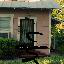

In [ ]:
# Let us see an image from test set.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img = tf.keras.preprocessing.image.load_img('training/hi/door_9_c6_10_none_edgeEnhance.jpg')
img

### Now that we have imported the data needed completely into the colab and we should do :
* Preprossing of the set of images, which we need to train and test.


In [ ]:
# # for background images into valid and train
# os.chdir('/content/training/background')
# if os.path.isdir('background_balanced') is False :
#   os.makedirs('background_balanced')

#   for c in random.sample(glob.glob('*jpg'), 1200) :
#     shutil.move(c, 'background_balanced')

#   shutil.move('background_balanced', '/content/training')

In [ ]:
train_path = '/content/training'
#valid_path = '/content/training/valid_train'
test_path = '/content'

In [ ]:
# from skimage import exposure

# def preprocessor(image) :
#   (image*255).astype(np.uint8)
#   grey_image = tf.image.rgb_to_grayscale(image)
#   # denoised_image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
#   contrast_image = exposure.equalize_adapthist(grey_image, clip_limit= 0.03)
#   rgb_image = tf.image.grayscale_to_rgb(grey_image)
#   return contrast_image
#   # return rgb_image

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input, validation_split=0.2, rescale = 1./255)
# train_datagen = ImageDataGenerator(preprocessing_function = preprocessor, validation_split=0.2)
train_batchs = train_datagen.flow_from_directory(directory = train_path, target_size = (64,64),classes = ['background', 'hi'], batch_size = 64, subset = 'training')
valid_batchs = train_datagen.flow_from_directory(directory = train_path, target_size = (64,64),classes = ['background', 'hi'], batch_size = 64, subset = 'validation')

Found 4700 images belonging to 2 classes.
Found 1175 images belonging to 2 classes.


In [ ]:
# Later on foucus on no of the batchs and check are we required to do some validation on training set as well.
# train_batchs = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input, validation_split = 0.2)\
#   .flow_from_directory(directory = train_path, target_size = (64,64),classes = ['background', 'hi'], batch_size = 32)
# valid_batchs = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
#   .flow_from_directory(directory = valid_path, target_size = (64,64),classes = ['background_valid', 'hi_valid'], batch_size = 32, shuffle = False)
# test_batchs = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
#   .flow_from_directory(directory = test_path, classes = ['test'], target_size = (64,64), batch_size = 32, shuffle = False)
# shuffle is false for test in order maintian order so that we can evaluate model using various metrics like confusion matrix and classification report.

In [ ]:
images, labels = next(train_batchs)

In [ ]:
def PlotImages(image_arr) :
  fix, axes = plt.subplots(1, 10, figsize = (20, 20))
  axes = axes.flatten()
  for image, ax in zip(image_arr, axes) :
    ax.imshow(image)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

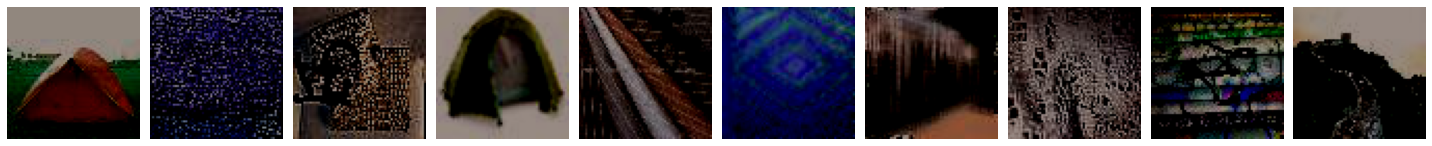

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
PlotImages(images)
print(labels[:10])

### Building and training CNN

In [ ]:
model = Sequential([
                    Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer=regularizers.l2(0.001), input_shape = (64, 64, 3)), 
                    BatchNormalization(axis=-1) ,
                    # Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer=regularizers.l2(0.001)), 
                    BatchNormalization(axis=-1) ,
                    MaxPool2D(pool_size = (3, 3), strides = 2), 
                    Dropout(0.3), 
                    Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer=regularizers.l2(0.001)), 
                    MaxPool2D(pool_size = (3, 3), strides = 2), 
                    Flatten(), 
                    Dense(units = 2, activation = 'softmax'), 
                    BatchNormalization(axis=-1), 

]) # Has 82 score earlier

# adding more layers
# model = Sequential([
#                     Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (64, 64, 3)), 
#                     MaxPool2D(pool_size = (2, 2), strides = 2),
#                     Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'), 
#                     MaxPool2D(pool_size = (2, 2), strides = 2), 
#                     Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'), 
#                     MaxPool2D(pool_size = (2, 2), strides = 2), 
#                     Flatten(), 
#                     Dense(units = 2, activation = 'softmax'), 

# ])  Has 85 score (layers increased layers are like 16, 32, 64)

# tuning by changing the model by changing filters size
# model = Sequential([
#                     Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (64, 64, 3)), 
#                     MaxPool2D(pool_size = (2, 2), strides = 2),
#                     Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'), 
#                     MaxPool2D(pool_size = (2, 2), strides = 2), 
#                     Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'), 
#                     MaxPool2D(pool_size = (2, 2), strides = 2), 
#                     Flatten(), 
#                     Dense(units = 2, activation = 'softmax'), 

# ]) # Has  score  85 (layers modified, layers are like 32, 64, 128)

# tuning model by changing kernel size
# model = Sequential([
#                     Conv2D(filters = 32, kernel_size = (5, 5), activation = 'relu', padding = 'same', input_shape = (64, 64, 3)), 
#                     MaxPool2D(pool_size = (2, 2), strides = 2),
#                     Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'), 
#                     MaxPool2D(pool_size = (2, 2), strides = 2), 
#                     Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'), 
#                     MaxPool2D(pool_size = (2, 2), strides = 2), 
#                     Flatten(), 
#                     Dense(units = 2, activation = 'softmax'), 

# ]) # Has  score 85  (kernel size modified on all layers, with three layers of 32, 64, 128)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0

In [ ]:
# Compile the model first
# Accuracy importance is known when we use the validation set along with the train set in fit so metrics is used to my model to understand its level and makes it self better for the test or future predictions
model.compile(optimizer = Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss= 'categorical_crossentropy', metrics = ['accuracy'])
# 1. need to take care of the learning rate as it effects the performance of the model.

In [ ]:
model.fit(x = train_batchs, epochs = 8, verbose = 2)
# Since we used tensor flow generator to store image unstructured data of array, it automatically stores the label i.e., answer to image we passed.

Epoch 1/8
74/74 - 22s - loss: nan - accuracy: 0.7543
Epoch 2/8
74/74 - 21s - loss: nan - accuracy: 0.7574
Epoch 3/8
74/74 - 21s - loss: nan - accuracy: 0.7574
Epoch 4/8
74/74 - 21s - loss: nan - accuracy: 0.7574
Epoch 5/8
74/74 - 21s - loss: nan - accuracy: 0.7574
Epoch 6/8
74/74 - 21s - loss: nan - accuracy: 0.7574
Epoch 7/8
74/74 - 21s - loss: nan - accuracy: 0.7574
Epoch 8/8
74/74 - 21s - loss: nan - accuracy: 0.7574


In [ ]:
# model.save('/content/model')
# Saving the model
## for importing model
# from tensorflow import keras
# model = keras.models.load_model('path/to/location')

In [ ]:
# We shall now use our model to predict on our test data
valid_images, valid_labels = next(valid_batchs) # can change this to test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

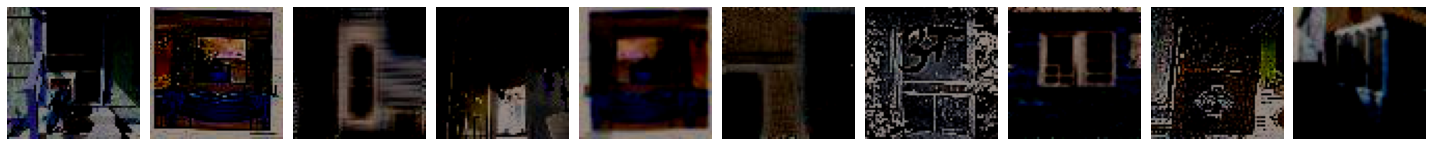

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
PlotImages(valid_images) # verify this part
print(valid_labels[:10])
 # can change this to test

In [ ]:
predictions = model.predict(x= valid_batchs, verbose = 0) # can change this to test

In [ ]:
# predictions
# Need to tune this further.
# add a function to get the evaluation
losses, accuracy = model.evaluate(valid_batchs, verbose = 0) 

In [ ]:
# np.round(predictions)
accuracy

0.757446825504303

In [ ]:
array = np.round(predictions)
array_ans = []
for index, pred in enumerate(array) :
  if pred[0] == 0 :
    array_ans.append(['hindi character :yes'])
  else :
    array_ans.append(['hindi character :no'])

In [ ]:
array_ans

[['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :yes'],
 ['hindi character :yes'],
 ['hindi character :yes'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi character :no'],
 ['hindi 

In [ ]:
counter = 0
for i in array_ans :
  if i == ['hindi character :yes'] :  
    counter = counter +1
counter

41

In [ ]:
json_obj = json.dumps(array_ans)
json_file = open('/content/answer1.json', "w")
with open('/content/answer1.json', "w") as json_file :
  json_file.write(json_obj)

### Tuning and Tweeking the model.

In [ ]:
# We need to use a confusion matrix to see our model performance since the labels are not availabe, we need to first figure out the labels manually and then use test classes as background and hi to get confusion matrix.
